In [1]:
import yfinance as yf
import pandas as pd
from statsmodels.tsa.stattools import coint
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

etfs = pd.read_csv('filtered_etfs.csv', header = None, names = ['ETF'])

tickers = etfs["ETF"].tolist()

start_date = '2015-01-01'
end_date = '2020-01-01'

prices = yf.download(tickers = tickers, start = start_date, end = end_date)['Close']

C:\Users\anair26\AppData\Local\Temp\ipykernel_25652\1887220627.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(tickers = tickers, start = start_date, end = end_date)['Close']
[*********************100%***********************]  62 of 62 completed


In [2]:
# rolling cointegration

window_size = 252
min_passes = 0.4
step = 21

candidate_pairs = []
cointegrated_pairs = []

category_prices = prices[tickers]

for i in range(len(tickers)):
    for j in range(i + 1, len(tickers)):
        candidate_pairs.append([tickers[i], tickers[j]])

for etf1, etf2 in candidate_pairs:
            
    df = category_prices[[etf1, etf2]].dropna()

    series1 = df.iloc[:, 0]
    series2 = df.iloc[:, 1]

    cointegrated_windows = 0
    total_windows = 0

    for start in range(0, len(df) - window_size + 1, step):
        end = start + window_size

        window_s1 = series1.iloc[start:end]
        window_s2 = series2.iloc[start:end]
                
        score, pvalue, _ = coint(window_s1, window_s2)
        total_windows += 1
                
        if pvalue < 0.1:
            cointegrated_windows += 1

    if cointegrated_windows / total_windows >= min_passes:
        cointegrated_pairs.append({'ETF1': etf1, 'ETF2': etf2, 'Pass %': cointegrated_windows / total_windows})
    print(f'ETF1: {etf1}, ETF2: {etf2}, Pass %: {cointegrated_windows / total_windows}')

cointegrated_pairs_df = pd.DataFrame(cointegrated_pairs)

cointegrated_pairs_df = cointegrated_pairs_df.sort_values('Pass %', ascending = False).reset_index(drop = True)
print(f'Rolling Cointegrated Pairs:')
cointegrated_pairs_df.head()


ETF1: IVE, ETF2: USMV, Pass %: 0.041666666666666664
ETF1: IVE, ETF2: SPYV, Pass %: 0.7291666666666666
ETF1: IVE, ETF2: SCHM, Pass %: 0.14583333333333334
ETF1: IVE, ETF2: IWS, Pass %: 0.2708333333333333
ETF1: IVE, ETF2: FV, Pass %: 0.041666666666666664
ETF1: IVE, ETF2: DVY, Pass %: 0.25
ETF1: IVE, ETF2: QQQ, Pass %: 0.20833333333333334
ETF1: IVE, ETF2: PRF, Pass %: 0.08333333333333333
ETF1: IVE, ETF2: VTI, Pass %: 0.1875
ETF1: IVE, ETF2: IJH, Pass %: 0.25
ETF1: IVE, ETF2: IUSG, Pass %: 0.1875
ETF1: IVE, ETF2: VO, Pass %: 0.0625
ETF1: IVE, ETF2: SDY, Pass %: 0.10416666666666667
ETF1: IVE, ETF2: IWB, Pass %: 0.1875
ETF1: IVE, ETF2: SPLV, Pass %: 0.041666666666666664
ETF1: IVE, ETF2: IWR, Pass %: 0.10416666666666667
ETF1: IVE, ETF2: FVD, Pass %: 0.020833333333333332
ETF1: IVE, ETF2: OEF, Pass %: 0.14583333333333334
ETF1: IVE, ETF2: HDV, Pass %: 0.0625
ETF1: IVE, ETF2: MDY, Pass %: 0.25
ETF1: IVE, ETF2: RSP, Pass %: 0.0625
ETF1: IVE, ETF2: ARKK, Pass %: 0.0625
ETF1: IVE, ETF2: SCHB, Pass %:

,ETF1,ETF2,Pass %
0,IWM,VTWO,0.937500
1,SPYG,IVW,0.812500
2,VOO,IVV,0.750000
3,IVE,SPYV,0.729167
4,IWB,SPLG,0.708333


In [6]:

category_prices = prices[tickers]

returns = category_prices.pct_change().dropna()

In [8]:
import numpy as np
import statsmodels.api as sm


# --- config ---
CORR_252_MAX = 0.98
CORR_060_MAX = 0.98
USE_ABS_CORR = True   # set False if you never consider inverse relationships

def trailing_corr(returns, t1, t2, window):
    r1 = returns[t1].dropna()
    r2 = returns[t2].dropna()
    r = pd.concat([r1, r2], axis=1, join='inner').dropna()
    if len(r) < window:
        return np.nan
    c = r.iloc[-window:].corr().iloc[0,1]
    return abs(c) if USE_ABS_CORR else c

# compute metrics and filter
def apply_corr_filter(cointegrated_pairs_df, returns):
    rows = []
    for t1, t2 in cointegrated_pairs_df[['ETF1','ETF2']].itertuples(index=False):
        c252 = trailing_corr(returns, t1, t2, 252)
        c060 = trailing_corr(returns, t1, t2, 60)
        keep = (c252 < CORR_252_MAX) and (c060 < CORR_060_MAX)
        rows.append({'ETF1': t1, 'ETF2': t2, 'corr_252': c252, 'corr_060': c060, 'keep_corr': keep})
    metrics = pd.DataFrame(rows)
    # join back and filter
    out = cointegrated_pairs_df.merge(metrics, on=['ETF1','ETF2'], how='left')
    filtered = out[out['keep_corr']].sort_values(by=['corr_252','corr_060'])
    return filtered, out

# run
corr_filtered_pairs_df, corr_metrics_df = apply_corr_filter(cointegrated_pairs_df, returns)
print("Kept after correlation filter:", len(corr_filtered_pairs_df), "of", len(cointegrated_pairs_df))
corr_filtered_pairs_df.head(19)

Kept after correlation filter: 19 of 32


,ETF1,ETF2,Pass %,corr_252,corr_060,keep_corr
26,DVY,OEF,0.437500,0.866815,0.817398,True
21,DVY,IWR,0.479167,0.906422,0.866858,True
23,IWR,DIA,0.458333,0.912385,0.856439,True
31,VO,DIA,0.416667,0.916070,0.853772,True
28,VTV,SPHQ,0.437500,0.919960,0.853777,True
22,SCHV,SPHQ,0.479167,0.922477,0.858231,True
25,RSP,DIA,0.437500,0.936982,0.890204,True
30,DVY,FVD,0.416667,0.939089,0.874033,True
29,DVY,VYM,0.416667,0.954264,0.929401,True
12,VO,SPY,0.541667,0.966261,0.950056,True


Clusters:
     ETF  Cluster        PC1        PC2
0    IVE        0 -11.184216  -9.162615
1   USMV        0 -25.859813   1.947467
2   SPYV        0 -10.366607  -8.808625
3   SCHM        1  10.370451  -7.751434
4    IWS        0  -1.393946 -16.839870
..   ...      ...        ...        ...
57  SPHD        0 -23.003994 -17.818080
58   DIA        0 -15.146534   3.880434
59  MTUM        0  -7.737828  25.621425
60   VYM        0 -17.973788  -5.729586
61  SPMD        1  19.770769 -16.754845

[62 rows x 4 columns]


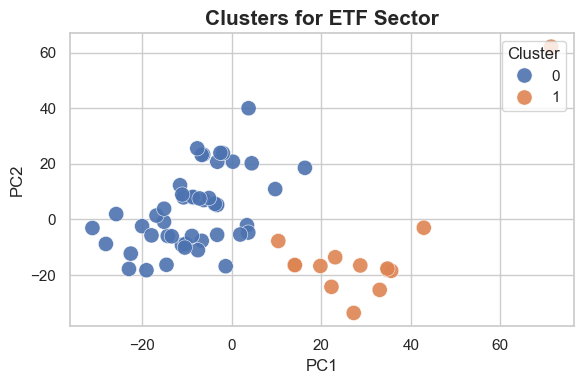

In [ ]:
# k-means / PCA


scaler = StandardScaler()
returns_scaled = scaler.fit_transform(returns.T)

pca = PCA(n_components = 2)
pca_components = pca.fit_transform(returns_scaled)

max_clusters = min(len(etfs) - 1, 10)

best_k = 2
best_score = -1

for k in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters = k, random_state = 42)
    labels = kmeans.fit_predict(pca_components)
    score = silhouette_score(pca_components, labels)

    if score > best_score:
        best_score = score
        best_k = k

kmeans = KMeans(n_clusters = best_k, random_state = 42)
labels = kmeans.fit_predict(pca_components)

cluster_df = pd.DataFrame({
    'ETF': returns.columns,
    'Cluster': labels,
    'PC1': pca_components[:, 0],
    'PC2': pca_components[:, 1]
})

print(f'Clusters:')
print(cluster_df)

sns.set_theme(style = 'whitegrid', font_scale = 1)

plt.figure(figsize = (6, 4))

sns.scatterplot(
    data = cluster_df,
    x = 'PC1',        
    y = 'PC2',
    hue = 'Cluster',
    s = 120, 
    linewidth = 0.4,
    alpha = 0.9 
)

plt.title(f'Clusters for ETF Sector', fontsize = 15, weight = 'bold')
plt.xlabel('PC1', fontsize = 12)
plt.ylabel('PC2', fontsize = 12)

plt.legend(title = 'Cluster', loc='upper right', frameon = True)

plt.tight_layout()
plt.show()

cluster_df = cluster_df.sort_values(by = 'Cluster')

In [13]:
final_candidates = []

cluster_zip = dict(zip(cluster_df['ETF'], cluster_df['Cluster']))

for _, row in corr_filtered_pairs_df.iterrows():
    etf1, etf2, pass_percentage = row['ETF1'], row['ETF2'], row['Pass %']
    if cluster_zip[etf1] == cluster_zip[etf2]:
        final_candidates.append([etf1, etf2, pass_percentage, cluster_zip[etf1]])

final_candidates = pd.DataFrame(final_candidates, columns=['ETF1','ETF2','RC Pass %','Cluster #'])
final_candidates = final_candidates.sort_values('RC Pass %', ascending=False).reset_index(drop=True)
print(final_candidates)


    ETF1  ETF2  RC Pass %  Cluster #
0     VO   IWB   0.583333          0
1     VO  SCHB   0.562500          0
2    VTI    VO   0.562500          0
3     VO   SPY   0.541667          0
4     VO  ITOT   0.541667          0
5     VO  SCHX   0.520833          0
6     VO  SPLG   0.520833          0
7     VO   VOO   0.500000          0
8     VO   IVV   0.500000          0
9    DVY   IWR   0.479167          0
10  SCHV  SPHQ   0.479167          0
11   IWR   DIA   0.458333          0
12   DVY   OEF   0.437500          0
13   VTV  SPHQ   0.437500          0
14   RSP   DIA   0.437500          0
15   DVY   VYM   0.416667          0
16    VO   DIA   0.416667          0
17   DVY   FVD   0.416667          0
